<a href="https://colab.research.google.com/github/atmark-techno/armadillo-iot-g4_model_zoo/blob/main/GoogleColabNotebooks/SuperResolution_OperationCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## モデルのダウンロード

In [1]:
%%bash
wget https://download.atmark-techno.com/armadillo-iot-g4/example/sample-models/super_resolution.tflite

--2022-08-19 07:18:30--  https://download.atmark-techno.com/armadillo-iot-g4/example/sample-models/super_resolution.tflite
Resolving download.atmark-techno.com (download.atmark-techno.com)... 221.114.106.147
Connecting to download.atmark-techno.com (download.atmark-techno.com)|221.114.106.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5150112 (4.9M)
Saving to: ‘super_resolution.tflite’

     0K .......... .......... .......... .......... ..........  0%  142K 35s
    50K .......... .......... .......... .......... ..........  1%  283K 26s
   100K .......... .......... .......... .......... ..........  2% 67.0M 17s
   150K .......... .......... .......... .......... ..........  3%  285K 17s
   200K .......... .......... .......... .......... ..........  4% 23.3M 14s
   250K .......... .......... .......... .......... ..........  5% 56.0M 11s
   300K .......... .......... .......... .......... ..........  6% 42.9M 9s
   350K .......... .......... .......... 

## テスト画像のダウンロード

In [2]:
# テスト画像をtest.jpgという名前で保存します。
%%bash
wget "https://unsplash.com/photos/OFyh9TpMyM8/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYwNjExMDAz&force=true&w=1920" -O test.jpg

--2022-08-19 07:18:33--  https://unsplash.com/photos/OFyh9TpMyM8/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYwNjExMDAz&force=true&w=1920
Resolving unsplash.com (unsplash.com)... 151.101.1.181, 151.101.193.181, 151.101.65.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.1.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1541625602330-2277a4c46182?ixlib=rb-1.2.1&dl=coen-van-de-broek-OFyh9TpMyM8-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb [following]
--2022-08-19 07:18:33--  https://images.unsplash.com/photo-1541625602330-2277a4c46182?ixlib=rb-1.2.1&dl=coen-van-de-broek-OFyh9TpMyM8-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb
Resolving images.unsplash.com (images.unsplash.com)... 146.75.34.208, 2a04:4e42:79::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.34.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348978 (341K) [image/jpeg]
Sa

# テストコード

## ライブラリのインポート

In [3]:
from tensorflow.lite.python.interpreter import Interpreter # Armadillo-IoT ゲートウェイ G4 実機上では、"from tflite_runtime import Interpreter" としてインポートしてください。
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Google colab上でcv2画像を表示するために必要なライブラリ

## interpreterの準備

In [4]:
interpreter = Interpreter('super_resolution.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

_, i_height, i_width, _ = input_details[0]['shape']

[{'name': 'input_0', 'index': 0, 'shape': array([ 1, 50, 50,  3], dtype=int32), 'shape_signature': array([ 1, 50, 50,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 1133, 'shape': array([  1, 200, 200,   3], dtype=int32), 'shape_signature': array([  1, 200, 200,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## テスト画像を読み込み、モデルに入力する形に整形する

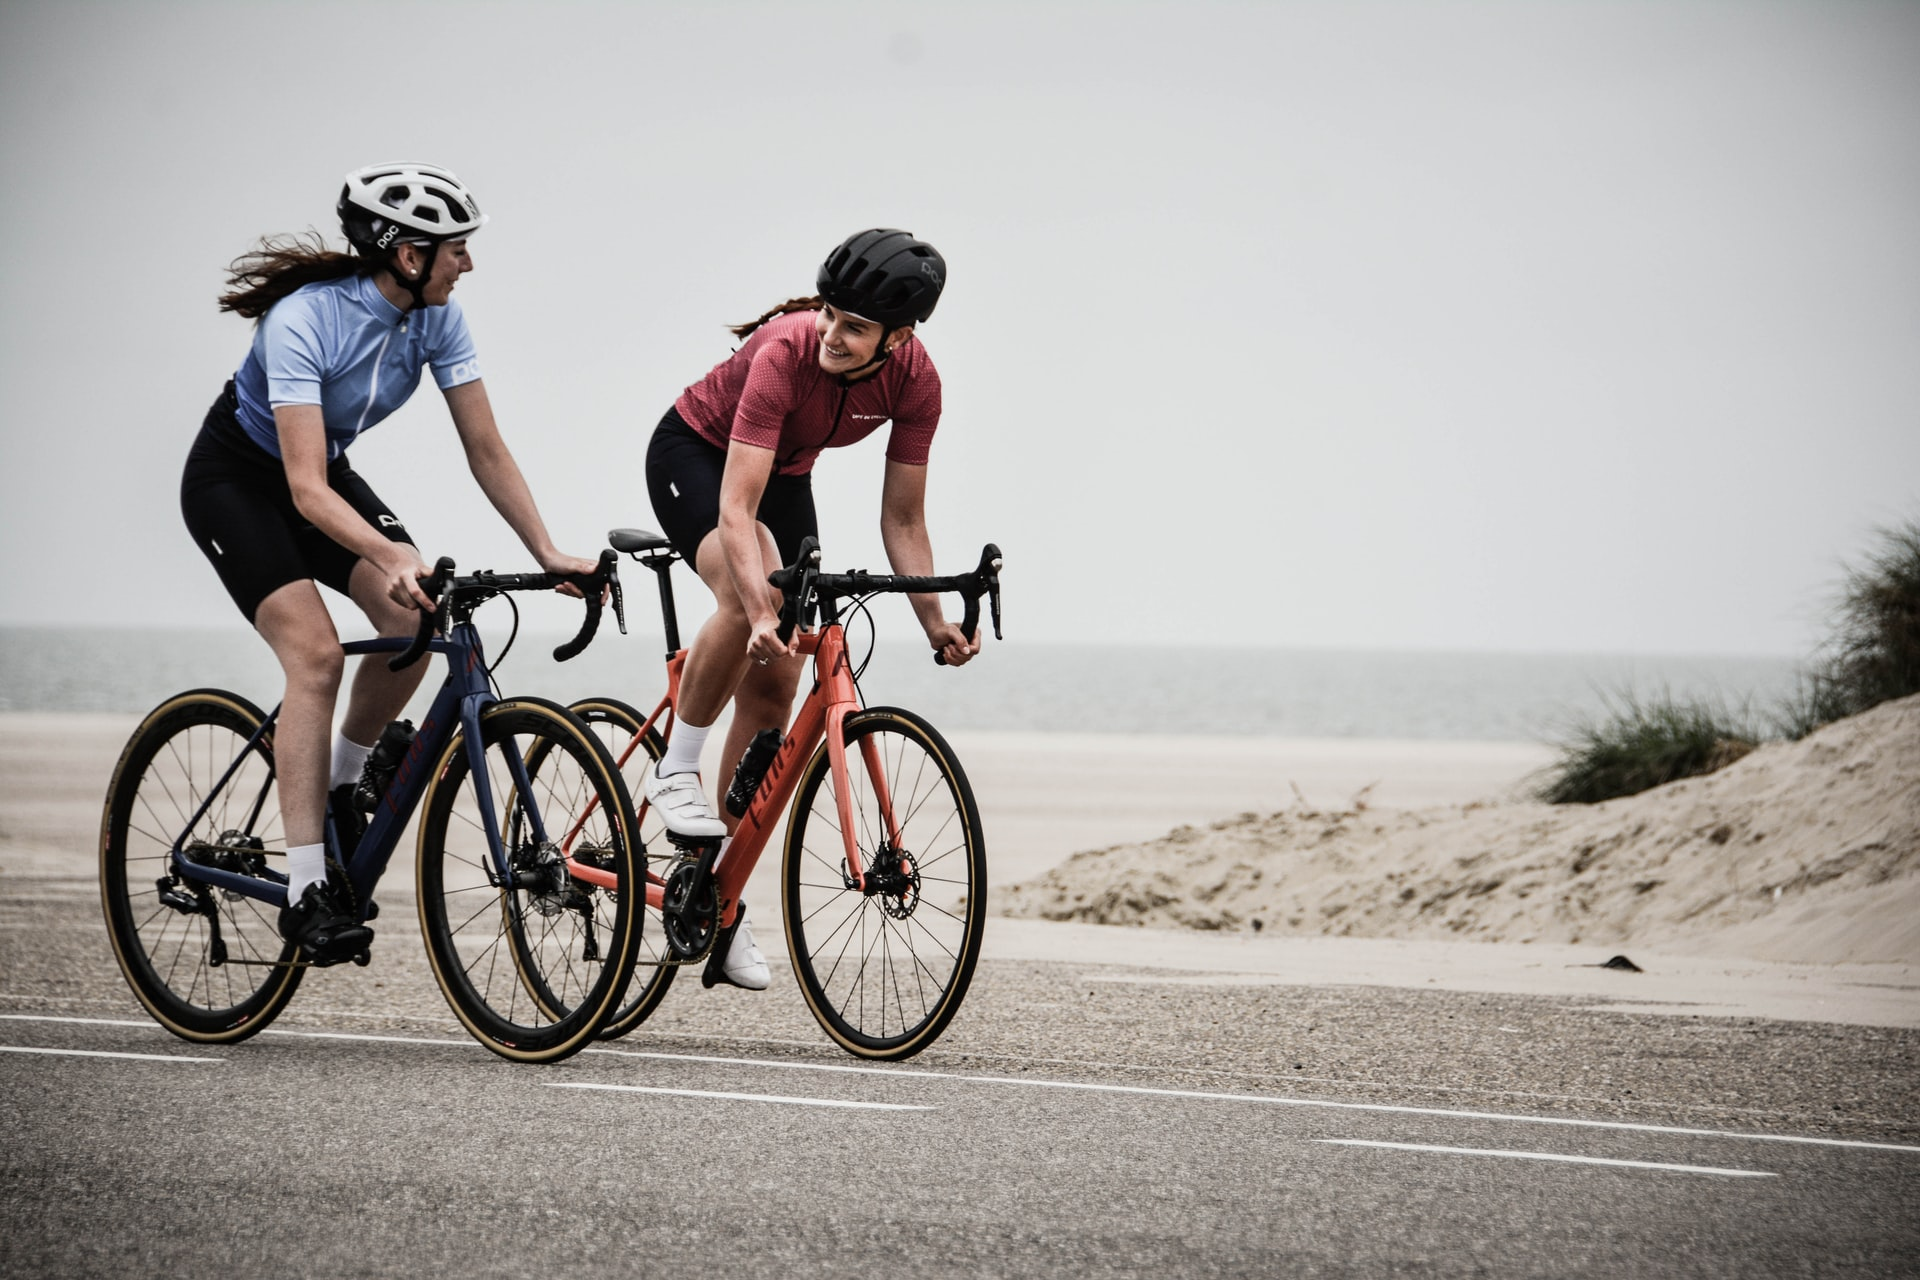

In [5]:
img = cv2.imread('test.jpg')
cv2_imshow(img)

テスト画像から50x50のサイズで切り抜く

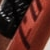

In [6]:
top = 780
bottom = top + 50
left = 730
right = left + 50
cropped = img[top:bottom, left:right].copy()
cv2_imshow(cropped)

In [7]:
input_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
input_image = np.expand_dims(input_image, 0).astype(input_details[0]['dtype'])

## 推論実行

In [8]:
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()

## 推論結果を抽出

In [9]:
output = interpreter.get_tensor(output_details[0]['index']).squeeze()

## 画像の後処理

In [10]:
output_img = np.clip(output, 0, 255)
output_img = np.round(output_img)
output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR).astype(np.uint8)

## 超解像前後の画像を表示

50x50の画像をcv2.resizeで200x200に引き伸ばした画像と、推論の結果得られた200x200の画像を比較します。  
解像感が比較しやすいように、resize時にinterpolationにINTER_NEARESTを指定しています。

超解像前


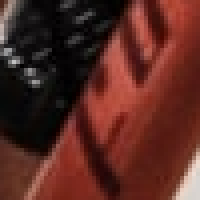

超解像後


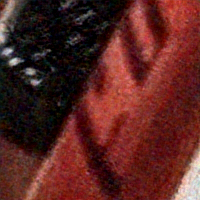

In [11]:
print('超解像前')
cv2_imshow(cv2.resize(cropped, (200, 200), interpolation=cv2.INTER_NEAREST))
print('超解像後')
cv2_imshow(output_img)